As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set.

Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the train-validation loss curve). Write your findings and analysis in paragraphs.


**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In this case please add the dataset you used to the submission zip file.

In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.



## Notes:
1. You can also consider using a small subset of the dataset if the training dataset is large
2. Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3. Your training will be much faster if you use a GPU (Edit -> Notebook settings). If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)
4. It is a best practise to leverage vector representations learned in Q1 in your training as starting point for the embedding layer.




In [ ]:
import math
import torch
import torch.nn as nn
import string
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np

def load_parallel_data(src_file, tgt_file):
    with open(src_file, 'r', encoding='utf-8') as f_src, open(tgt_file, 'r', encoding='utf-8') as f_tgt:
        src_sentences = f_src.read().lower().split('\n')
        tgt_sentences = f_tgt.read().lower().split('\n')
    
    return src_sentences[:2000], tgt_sentences[:2000]

def tokenize_sentence(sentence):
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    return sentence.strip().split()

def preprocess_parallel_data(src_sentences, tgt_sentences):
    tokenized_src = [tokenize_sentence(sent) for sent in src_sentences]
    tokenized_tgt = [tokenize_sentence(sent) for sent in tgt_sentences]
    return tokenized_src, tokenized_tgt

def build_vocab(sentences, min_freq=2):  # Reduced min_freq to include more words
    all_tokens = [token for sent in sentences for token in sent]
    counter = Counter(all_tokens)
    vocab = [word for word, freq in counter.items() if freq >= min_freq]

    vocab = ['<pad>', '<unk>', '<sos>', '<eos>'] + sorted(vocab)
    
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for word, i in word2idx.items()}
    
    return word2idx, idx2word

def encode_sentences(sentences, word2idx, max_len, add_sos_eos=False):
    encoded = []
    for sent in sentences:
        if add_sos_eos:
            sent = ['<sos>'] + sent + ['<eos>']
        idxs = [word2idx.get(token, word2idx['<unk>']) for token in sent]
        idxs = idxs[:max_len]
        idxs += [word2idx['<pad>']] * (max_len - len(idxs))
        encoded.append(idxs)
    return torch.tensor(encoded)

# Data preprocessing
src_raw, tgt_raw = load_parallel_data('europarl-v7.de-en.en', 'europarl-v7.de-en.de')
src_tok, tgt_tok = preprocess_parallel_data(src_raw, tgt_raw)

src_word2idx, src_idx2word = build_vocab(src_tok)
tgt_word2idx, tgt_idx2word = build_vocab(tgt_tok)

MAX_LEN_SRC = 60
MAX_LEN_TGT = 60

X = encode_sentences(src_tok, src_word2idx, MAX_LEN_SRC)
Y = encode_sentences(tgt_tok, tgt_word2idx, MAX_LEN_TGT, add_sos_eos=True)

In [ ]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)

class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class ResidualConnection(nn.Module):
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


In [ ]:

class EncoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderBlock(nn.Module):
    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

class Decoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

class ProjectionLayer(nn.Module):
    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return self.proj(x)

class Transformer(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: torch.Tensor, tgt: torch.Tensor, tgt_mask: torch.Tensor):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def project(self, x):
        return self.projection_layer(x)

    def create_src_mask(self, src, pad_idx):
        return (src != pad_idx).unsqueeze(1).unsqueeze(2)

    def create_tgt_mask(self, tgt, pad_idx):
        batch_size, tgt_len = tgt.shape
        device = tgt.device
        
        pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)
        causal_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=device)).bool()
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
        
        return pad_mask & causal_mask

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        if src_mask is None:
            src_mask = self.create_src_mask(src, pad_idx=0)
        if tgt_mask is None:
            tgt_mask = self.create_tgt_mask(tgt, pad_idx=0)
            
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(encoder_output, src_mask, tgt, tgt_mask)
        output = self.project(decoder_output)
        
        return output


def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=256, N: int=4, h: int=8, dropout: float=0.3, d_ff: int=1024) -> Transformer:
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))
    
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, src_tensor, tgt_tensor):
        self.src = src_tensor
        self.tgt = tgt_tensor

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# Split data 
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = TranslationDataset(X_train, Y_train)
val_dataset = TranslationDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_IDX = tgt_word2idx['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)  # Label smoothing

model = build_transformer(
    src_vocab_size=len(src_word2idx),
    tgt_vocab_size=len(tgt_word2idx),
    src_seq_len=MAX_LEN_SRC,
    tgt_seq_len=MAX_LEN_TGT,
    d_model=256, 
    N=4,         
    h=8,
    dropout=0.3, 
    d_ff=1024     
)
model.to(device)

# Lower learning rate and weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask = model.create_src_mask(src, PAD_IDX)
        tgt_mask = model.create_tgt_mask(tgt_input, PAD_IDX)

        preds = model(src, tgt_input, src_mask, tgt_mask)

        preds = preds.reshape(-1, preds.shape[-1])
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(preds, tgt_output)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_mask = model.create_src_mask(src, PAD_IDX)
            tgt_mask = model.create_tgt_mask(tgt_input, PAD_IDX)

            preds = model(src, tgt_input, src_mask, tgt_mask)
            preds = preds.reshape(-1, preds.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(preds, tgt_output)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience



Training model with 9750194 parameters
Epoch 1: Train Loss = 6.9961, Val Loss = 6.4459
New best model saved with validation loss: 6.4459
Epoch 2: Train Loss = 6.3732, Val Loss = 6.3705
New best model saved with validation loss: 6.3705
Epoch 3: Train Loss = 6.3045, Val Loss = 6.3165
New best model saved with validation loss: 6.3165
Epoch 4: Train Loss = 6.2329, Val Loss = 6.2302
New best model saved with validation loss: 6.2302
Epoch 5: Train Loss = 6.1148, Val Loss = 6.1654
New best model saved with validation loss: 6.1654
Epoch 6: Train Loss = 5.9958, Val Loss = 6.0291
New best model saved with validation loss: 6.0291
Epoch 7: Train Loss = 5.8860, Val Loss = 5.9630
New best model saved with validation loss: 5.9630
Epoch 8: Train Loss = 5.7870, Val Loss = 5.9073
New best model saved with validation loss: 5.9073
Epoch 9: Train Loss = 5.7018, Val Loss = 5.8377
New best model saved with validation loss: 5.8377
Epoch 10: Train Loss = 5.6295, Val Loss = 5.8359
New best model saved with vali

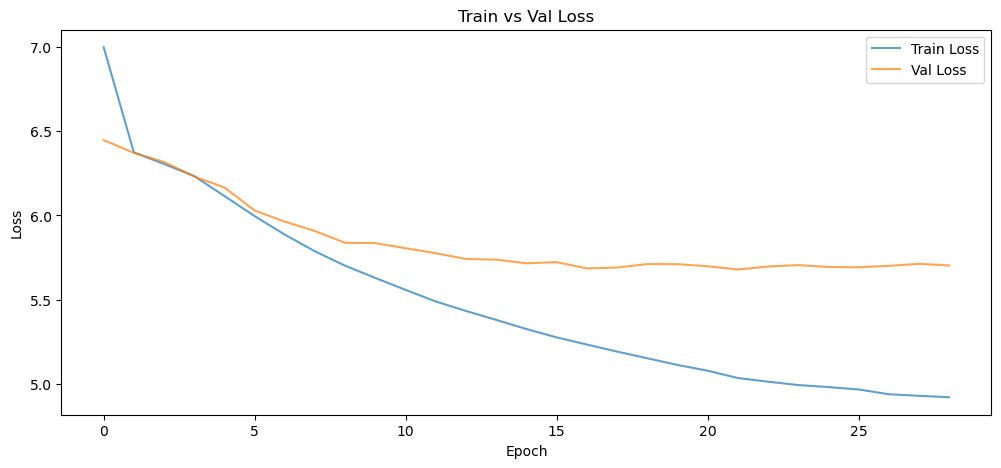

In [ ]:
# Training loop with early stopping
EPOCHS = 30 
train_losses = []
val_losses = []
early_stopping = EarlyStopping(patience=7)

print(f"Training model with {sum(p.numel() for p in model.parameters())} parameters")
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved with validation loss: {val_loss:.4f}")
    
    # Early stopping
    if early_stopping(val_loss):
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model for evaluation
model.load_state_dict(torch.load("best_model.pth"))

# Plot training curves
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Val Loss', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Val Loss")


def translate(model, src_tensor, src_word2idx, tgt_word2idx, tgt_idx2word, device, max_len=45):
    model.eval()
    src_tensor = src_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        src_mask = model.create_src_mask(src_tensor, src_word2idx['<pad>'])
        encoder_output = model.encode(src_tensor, src_mask)
        
        tgt_indexes = [tgt_word2idx['<sos>']]

        for _ in range(max_len):
            tgt_tensor = torch.tensor(tgt_indexes, device=device).unsqueeze(0)
            tgt_mask = model.create_tgt_mask(tgt_tensor, tgt_word2idx['<pad>'])

            decoder_output = model.decode(encoder_output, src_mask, tgt_tensor, tgt_mask)
            output = model.project(decoder_output)

            next_token = output[0, -1].argmax().item()
            if next_token == tgt_word2idx['<eos>']:
                break
            tgt_indexes.append(next_token)

    return [tgt_idx2word[idx] for idx in tgt_indexes[1:]]

# BLEU evaluation on a subset to avoid memory issues
sample_size = min(100, len(X_val))
indices = np.random.choice(len(X_val), sample_size, replace=False)

references = []
hypotheses = []

print("Evaluating BLEU score...")
for i, idx in enumerate(indices):
    if i % 20 == 0:
        print(f"Progress: {i}/{sample_size}")
        
    src_sentence = X_val[idx]
    tgt_sentence = Y_val[idx]
    
    pred_tokens = translate(model, src_sentence, src_word2idx, tgt_word2idx, tgt_idx2word, device)
    true_tokens = [tgt_idx2word[idx.item()] for idx in tgt_sentence if idx.item() not in {tgt_word2idx['<pad>'], tgt_word2idx['<sos>'], tgt_word2idx['<eos>']}]
    
    references.append([true_tokens])
    hypotheses.append(pred_tokens)

smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
print(f"BLEU score on validation set: {bleu_score:.4f}")

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*